# **Home Credit 2024 - Baseline Notebook**

## **1. Importing libraries, creating helping classes**

In [1]:
import os
import gc
from glob import glob
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import polars as pl

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import roc_curve, auc

from tqdm.notebook import tqdm


import joblib

import lightgbm as lgb

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import ipywidgets as widgets
from IPython.display import display
import time

progress_bar = widgets.IntProgress(
    value=0,
    min=0,
    max=100,
    description='Progress:',
    bar_style='',  # 'success', 'info', 'warning', 'danger' or ''
    style={'bar_color': 'blue'},
    orientation='horizontal'
)

display(progress_bar)

# Simulating a long-running task
for i in range(100):
    time.sleep(0.1)  # Simulating computation
    progress_bar.value = i + 1


IntProgress(value=0, description='Progress:', style=ProgressStyle(bar_color='blue'))

KeyboardInterrupt: 

### Pre-Fitted Voting Model

In [3]:
# This class combines the models that were trained with cross-validation.


class VotingModel(BaseEstimator, RegressorMixin):
    def __init__(self, estimators):
        super().__init__()
        self.estimators = estimators
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        y_preds = [estimator.predict(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)
    
    # def predict_proba(self, X):
    #     y_preds = [estimator.predict_proba(X) for estimator in self.estimators]
    #     for i, estimator in enumerate(self.estimators):
    #         y_preds[i] = estimator.predict_proba(X)
    #     return np.mean(y_preds, axis=0)

    #     return np.mean(y_preds, axis=0)
    def predict_proba(self, X):
        y_preds = [estimator.predict_proba(X) for estimator in self.estimators]
        # Use tqdm to create a progress bar during the prediction
        with tqdm(total=len(self.estimators), desc="Predicting", unit=" models") as pbar:
            for i, estimator in enumerate(self.estimators):
                y_preds[i] = estimator.predict_proba(X)
                pbar.update(1)  # Update the progress bar
        return np.mean(y_preds, axis=0)
    
    def add_feature_importances(self, feature_importances_list):
        self.feature_importances=feature_importances_list
        return self
    
    def get_feature_importances(self, aggregation_method=np.mean):
        # Aggregate feature importances across all models
        if all(importances is not None for importances in self.feature_importances):
            combined_importances = aggregation_method(self.feature_importances, axis=0)
        else:
            combined_importances = None
        
        return combined_importances

### Pipeline

In [4]:
# Class for modifying the dataframes


class Pipeline:
    @staticmethod
    
    
    # Sets datatypes accordingly
    def set_table_dtypes(df):
        for col in df.columns:
            if col in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(col).cast(pl.Int64))
            elif col in ["date_decision"]:
                df = df.with_columns(pl.col(col).cast(pl.Date))
            elif col[-1] in ("P", "A"):
                df = df.with_columns(pl.col(col).cast(pl.Float64))
            elif col[-1] in ("M",):
                df = df.with_columns(pl.col(col).cast(pl.String))
            elif col[-1] in ("D",):
                df = df.with_columns(pl.col(col).cast(pl.Date))            

        return df
    
    
    # Changes the values of all date columns. The result will not be a date but number of days since date_decision.
    @staticmethod
    def handle_dates(df):
        for col in df.columns:
            if col[-1] in ("D",):
                df = df.with_columns(pl.col(col) - pl.col("date_decision"))
                df = df.with_columns(pl.col(col).dt.total_days())
                
        df = df.drop("date_decision", "MONTH")

        return df
    
    # It drops columns with a lot of NaN values.
    @staticmethod
    def filter_cols(df):
        for col in df.columns:
            if col not in ["target", "case_id", "WEEK_NUM"]:
                isnull = df[col].is_null().mean()

                if isnull > 0.95:
                    df = df.drop(col)

        for col in df.columns:
            if (col not in ["target", "case_id", "WEEK_NUM"]) & (df[col].dtype == pl.String):
                freq = df[col].n_unique()

                if (freq == 1) | (freq > 200):
                    df = df.drop(col)

        return df

### Memory usage reduction function

In [5]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

### Automatic Aggregation

In [6]:
# Class that helps with aggregation.

class Aggregator:
    
    @staticmethod
    def num_expr(df):
        cols = [col for col in df.columns if col[-1] in ("P", "A")]

        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max

    @staticmethod
    def date_expr(df):
        cols = [col for col in df.columns if col[-1] in ("D",)]

        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max

    @staticmethod
    def str_expr(df):
        cols = [col for col in df.columns if col[-1] in ("M",)]
        
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max

    @staticmethod
    def other_expr(df):
        cols = [col for col in df.columns if col[-1] in ("T", "L")]
        
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max
    
    @staticmethod
    def count_expr(df):
        cols = [col for col in df.columns if "num_group" in col]

        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max
    
    
    
    
    
    @staticmethod
    def num_expr_min(df):
        cols = [col for col in df.columns if col[-1] in ("P", "A")]

        expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]

        return expr_min

    @staticmethod
    def date_expr_min(df):
        cols = [col for col in df.columns if col[-1] in ("D",)]

        expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]

        return expr_min

    @staticmethod
    def str_expr_min(df):
        cols = [col for col in df.columns if col[-1] in ("M",)]
        
        expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]

        return expr_min

    @staticmethod
    def other_expr_min(df):
        cols = [col for col in df.columns if col[-1] in ("T", "L")]
        
        expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]

        return expr_min
    
    @staticmethod
    def count_expr_min(df):
        cols = [col for col in df.columns if "num_group" in col]

        expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]

        return expr_min
    
    
    
    
    
    

  
    
    
    @staticmethod
    def num_expr_cnt(df):
        cols = [col for col in df.columns if col[-1] in ("P", "A")]

        expr_cnt = [pl.count(col).alias(f"cnt_{col}") for col in cols]

        return expr_cnt

    @staticmethod
    def date_expr_cnt(df):
        cols = [col for col in df.columns if col[-1] in ("D",)]

        expr_cnt = [pl.count(col).alias(f"cnt_{col}") for col in cols]

        return expr_cnt

    @staticmethod
    def str_expr_cnt(df):
        cols = [col for col in df.columns if col[-1] in ("M",)]
        
        expr_cnt = [pl.count(col).alias(f"cnt_{col}") for col in cols]

        return expr_cnt

    @staticmethod
    def other_expr_cnt(df):
        cols = [col for col in df.columns if col[-1] in ("T", "L")]
        
        expr_cnt = [pl.count(col).alias(f"cnt_{col}") for col in cols]

        return expr_cnt
    
    @staticmethod
    def count_expr_cnt(df):
        cols = [col for col in df.columns if "num_group" in col]

        expr_cnt = [pl.count(col).alias(f"cnt_{col}") for col in cols]

        return expr_cnt
    
    
    
    
    
    
    
    
    

    @staticmethod
    
    def num_expr_mean(df):
        cols = [col for col in df.columns if col[-1] in ("P", "A")]

        expr_mean = [pl.mean(col).alias(f"mean_{col}") for col in cols]

        return expr_mean

    @staticmethod
    def date_expr_mean(df):
        cols = [col for col in df.columns if col[-1] in ("D",)]

        expr_mean = [pl.mean(col).alias(f"mean_{col}") for col in cols]

        return expr_mean

    @staticmethod
    def str_expr_mean(df):
        cols = [col for col in df.columns if col[-1] in ("M",)]
        
        expr_mean = [pl.mean(col).alias(f"mean_{col}") for col in cols]

        return expr_mean

    @staticmethod
    def other_expr_mean(df):
        cols = [col for col in df.columns if col[-1] in ("T", "L")]
        
        expr_mean = [pl.mean(col).alias(f"mean_{col}") for col in cols]

        return expr_mean
    
    @staticmethod
    def count_expr_mean(df):
        cols = [col for col in df.columns if "num_group" in col]

        expr_mean = [pl.mean(col).alias(f"mean_{col}") for col in cols]

        return expr_mean

    @staticmethod
    def get_exprs(df):
        exprs = Aggregator.num_expr(df) + \
                Aggregator.date_expr(df) + \
                Aggregator.str_expr(df) + \
                Aggregator.other_expr(df) + \
                Aggregator.count_expr(df) + \
                Aggregator.num_expr_mean(df) + \
                Aggregator.date_expr_mean(df) + \
                Aggregator.str_expr_mean(df) + \
                Aggregator.other_expr_mean(df) + \
                Aggregator.count_expr_mean(df) + \
                Aggregator.num_expr_min(df) + \
                Aggregator.date_expr_min(df) + \
                Aggregator.str_expr_min(df) + \
                Aggregator.other_expr_min(df) + \
                Aggregator.count_expr_min(df)

        return exprs
        

### File I/O

In [7]:
def read_file(path, depth=None):
    df = pl.read_parquet(path)
    df = df.pipe(Pipeline.set_table_dtypes)
    
    if depth in [1, 2]:
        df = df.group_by("case_id").agg(Aggregator.get_exprs(df))
      
    
    return df

def read_files(regex_path, depth=None):
    chunks = []
    for path in glob(str(regex_path)):
        chunks.append(pl.read_parquet(path).pipe(Pipeline.set_table_dtypes))
        
    df = pl.concat(chunks, how="vertical_relaxed")
    if depth in [1, 2]:
        df = df.group_by("case_id").agg(Aggregator.get_exprs(df))
       
    return df

### Feature Engineering

In [8]:
def feature_eng(df_base, depth_0, depth_1, depth_2):
    df_base = (
        df_base
        .with_columns(
            year_decision = pl.col("date_decision").dt.year(),
            month_decision = pl.col("date_decision").dt.month(),
            weekday_decision = pl.col("date_decision").dt.weekday(),
        )
    )
        
    for i, df in enumerate(depth_0 + depth_1 + depth_2):
        df_base = df_base.join(df, how="left", on="case_id", suffix=f"_{i}")
        
    df_base = df_base.pipe(Pipeline.handle_dates)
    
    return df_base

In [9]:
def to_pandas(df_data, cat_cols=None):
    df_data = df_data.to_pandas()
    
    if cat_cols is None:
        cat_cols = list(df_data.select_dtypes("object").columns)
    
    df_data[cat_cols] = df_data[cat_cols].astype("category")
    
    return df_data, cat_cols

### Configuration

In [10]:
# ROOT            = Path("/kaggle/input/home-credit-credit-risk-model-stability")
# TRAIN_DIR       = ROOT / "parquet_files" / "train"
# TEST_DIR        = ROOT / "parquet_files" / "test"

ROOT            = Path("./")
TRAIN_DIR       = ROOT / "parquet_files" / "train"
TEST_DIR        = ROOT / "parquet_files" / "test"
!dir {TRAIN_DIR}


 Volume in drive C is Windows-SSD
 Volume Serial Number is 045F-6EED

 Directory of c:\Users\Rijul\Documents\coding\Work\Kaggle\Home Credit Risk 2024 - Stability\parquet_files\train

15-03-2024  17:06    <DIR>          .
15-03-2024  17:06    <DIR>          ..
11-03-2024  17:29       106,951,598 train_applprev_1_0.parquet
11-03-2024  17:29        72,860,971 train_applprev_1_1.parquet
11-03-2024  17:29        28,484,608 train_applprev_2.parquet
11-03-2024  17:29         7,048,047 train_base.parquet
11-03-2024  17:29        64,863,053 train_credit_bureau_a_1_0.parquet
11-03-2024  17:29       183,293,106 train_credit_bureau_a_1_1.parquet
11-03-2024  17:30       123,506,425 train_credit_bureau_a_1_2.parquet
11-03-2024  17:30        71,774,171 train_credit_bureau_a_1_3.parquet
11-03-2024  17:30         5,786,632 train_credit_bureau_a_2_0.parquet
11-03-2024  17:30        10,006,927 train_credit_bureau_a_2_1.parquet
11-03-2024  17:30         7,646,586 train_credit_bureau_a_2_10.parquet
11-03-2

## **3. Preparing dataset and feature engineering**

In [11]:
data_store = {
    "df_base": read_file(TRAIN_DIR / "train_base.parquet"),
    "depth_0": [
        read_file(TRAIN_DIR / "train_static_cb_0.parquet"),
        read_files(TRAIN_DIR / "train_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TRAIN_DIR / "train_applprev_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_a_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_c_1.parquet", 1),
        read_file(TRAIN_DIR / "train_credit_bureau_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_other_1.parquet", 1),
        read_file(TRAIN_DIR / "train_person_1.parquet", 1),
        read_file(TRAIN_DIR / "train_deposit_1.parquet", 1),
        read_file(TRAIN_DIR / "train_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TRAIN_DIR / "train_credit_bureau_b_2.parquet", 2),
    ]
}

In [12]:
df_train = feature_eng(**data_store)

print("train data shape:\t", df_train.shape)

train data shape:	 (1526659, 681)


### Test Files Read & Feature Engineering

In [13]:
data_store = {
    "df_base": read_file(TEST_DIR / "test_base.parquet"),
    "depth_0": [
        read_file(TEST_DIR / "test_static_cb_0.parquet"),
        read_files(TEST_DIR / "test_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TEST_DIR / "test_applprev_1_*.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_a_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_b_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_c_1.parquet", 1),
        read_file(TEST_DIR / "test_credit_bureau_b_1.parquet", 1),
        read_file(TEST_DIR / "test_other_1.parquet", 1),
        read_file(TEST_DIR / "test_person_1.parquet", 1),
        read_file(TEST_DIR / "test_deposit_1.parquet", 1),
        read_file(TEST_DIR / "test_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TEST_DIR / "test_credit_bureau_b_2.parquet", 2),
    ]
}

In [15]:
df_test = feature_eng(**data_store)

print("test data shape:\t", df_test.shape)

test data shape:	 (10, 680)


### Feature Elimination

In [16]:
df_train = df_train.pipe(Pipeline.filter_cols)
df_test = df_test.select([col for col in df_train.columns if col != "target"])

print("train data shape:\t", df_train.shape)
print("test data shape:\t", df_test.shape)

train data shape:	 (1526659, 395)
test data shape:	 (10, 394)


### Pandas Conversion

In [17]:
df_train, cat_cols = to_pandas(df_train)
df_test, cat_cols = to_pandas(df_test, cat_cols)
df_train=reduce_mem_usage(df_train)
df_test=reduce_mem_usage(df_test)

Memory usage after optimization is: 1255.05 MB
Decreased by 66.4%
Memory usage after optimization is: 0.02 MB
Decreased by 42.3%


### Add external dataset

In [ ]:
!ls /kaggle/input/

In [22]:

irrelevant_features=['year_decision',
 'assignmentdate_238D',
 'assignmentdate_4527235D',
 'description_5085714M',
 'education_88M',
 'maritalst_893M',
 'pmtcount_4527229L',
 'pmtcount_693L',
 'requesttype_4525192L',
 'responsedate_1012D',
 'responsedate_4917613D',
 'actualdpdtolerance_344P',
 'annuitynextmonth_57A',
 'applicationcnt_361L',
 'applications30d_658L',
 'applicationscnt_1086L',
 'applicationscnt_464L',
 'applicationscnt_629L',
 'bankacctype_710L',
 'cardtype_51L',
 'clientscnt12m_3712952L',
 'clientscnt3m_3712950L',
 'clientscnt6m_3712949L',
 'clientscnt_100L',
 'clientscnt_1022L',
 'clientscnt_1071L',
 'clientscnt_1130L',
 'clientscnt_157L',
 'clientscnt_257L',
 'clientscnt_304L',
 'clientscnt_360L',
 'clientscnt_493L',
 'clientscnt_533L',
 'clientscnt_887L',
 'clientscnt_946L',
 'commnoinclast6m_3546845L',
 'currdebtcredtyperange_828A',
 'deferredmnthsnum_166L',
 'equalitydataagreement_891L',
 'inittransactioncode_186L',
 'isdebitcard_729L',
 'lastrejectcommodtypec_5251769M',
 'lastrejectreasonclient_4145040M',
 'mastercontrelectronic_519L',
 'mastercontrexist_109L',
 'numactivecreds_622L',
 'numactivecredschannel_414L',
 'numactiverelcontr_750L',
 'numcontrs3months_479L',
 'numinstls_657L',
 'numinstpaidearly5dest_4493211L',
 'numinstpaidearly5dobd_4499205L',
 'numinstpaidearlyest_4493214L',
 'numnotactivated_1143L',
 'numpmtchanneldd_318L',
 'opencred_647L',
 'paytype1st_925L',
 'paytype_783L',
 'posfpd10lastmonth_333P',
 'posfpd30lastmonth_3976960P',
 'posfstqpd30lastmonth_3976962P',
 'sellerplacecnt_915L',
 'twobodfilling_608L',
 'typesuite_864L',
 'max_actualdpd_943P',
 'max_credacc_credlmt_575A',
 'max_credacc_maxhisbal_375A',
 'max_credacc_minhisbal_90A',
 'max_revolvingaccount_394A',
 'max_cancelreason_3545846M',
 'max_postype_4733339M',
 'max_rejectreason_755M',
 'max_rejectreasonclient_4145042M',
 'max_credacc_transactions_402L',
 'max_credtype_587L',
 'max_inittransactioncode_279L',
 'max_isbidproduct_390L',
 'max_isdebitcard_527L',
 'max_status_219L',
 'mean_actualdpd_943P',
 'mean_credacc_maxhisbal_375A',
 'mean_revolvingaccount_394A',
 'mean_credacc_transactions_402L', 
 'mean_isbidproduct_390L',
 'mean_isdebitcard_527L',
 'max_recorddate_4527225D',
 'mean_recorddate_4527225D',
 'max_deductiondate_4917603D',
 'mean_num_group1_4',
 'max_num_group1_5',
 'max_education_927M',
 'max_empladdr_district_926M',
 'max_empladdr_zipcode_114M',
 'max_contaddr_matchlist_1032L',
 'max_contaddr_smempladdr_334L',
 'max_empl_employedtotal_800L',
 'max_housetype_905L',
 'max_personindex_1023L',
 'max_persontype_1072L',
 'max_persontype_792L',
 'max_remitter_829L',
 'max_role_1084L',
 'max_safeguarantyflag_411L',
 'max_type_25L',
 'max_num_group1_8',
 'mean_contaddr_matchlist_1032L',
 'mean_contaddr_smempladdr_334L',
 'mean_personindex_1023L',
 'mean_persontype_1072L',
 'mean_persontype_792L',
 'mean_remitter_829L',
 'mean_safeguarantyflag_411L',
 'mean_num_group1_8',
 'max_amount_416A',
 'max_openingdate_313D',
 'max_num_group1_9',
 'mean_amount_416A',
 'mean_openingdate_313D',
 'mean_num_group1_9',
 'max_openingdate_857D',
 'max_num_group1_10',
 'mean_openingdate_857D',
 'mean_num_group1_10',
 ]
len(irrelevant_features)

123

In [19]:
df_train.drop(irrelevant_features, axis=1, inplace=True)
df_test.drop(irrelevant_features, axis=1, inplace=True)

In [20]:
df_train.shape

(1526659, 272)

### Garbage Collection

In [23]:
del data_store

gc.collect()

493

### EDA

In [24]:
print("Train is duplicated:\t", df_train["case_id"].duplicated().any())
print("Train Week Range:\t", (df_train["WEEK_NUM"].min(), df_train["WEEK_NUM"].max()))

print()

print("Test is duplicated:\t", df_test["case_id"].duplicated().any())
print("Test Week Range:\t", (df_test["WEEK_NUM"].min(), df_test["WEEK_NUM"].max()))

Train is duplicated:	 False
Train Week Range:	 (0, 91)

Test is duplicated:	 False
Test Week Range:	 (100, 100)


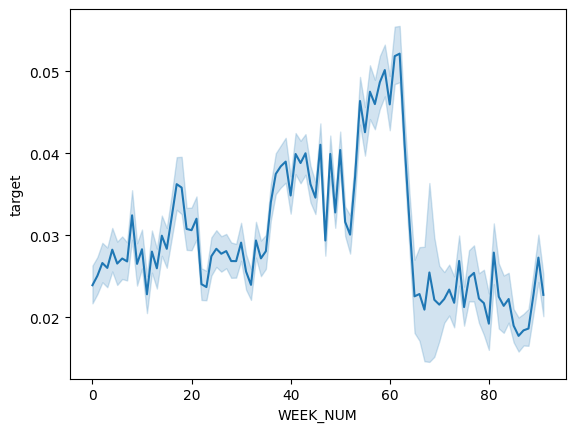

In [25]:
sns.lineplot(
    data=df_train,
    x="WEEK_NUM",
    y="target",
)
plt.show()

In [26]:
#df_train = df_train[df_train['WEEK_NUM'] <= 60]
df_train

,case_id,WEEK_NUM,target,month_decision,weekday_decision,birthdate_574D,contractssum_5085716L,dateofbirth_337D,days120_123L,days180_256L,...,min_remitter_829L,min_safeguarantyflag_411L,min_sex_738L,min_type_25L,min_num_group1_8,min_amount_416A,min_openingdate_313D,min_num_group1_9,min_openingdate_857D,min_num_group1_10
0,0,0,0,1,4,NaN,NaN,NaN,NaN,NaN,...,False,True,F,PHONE,0,NaN,NaN,NaN,NaN,NaN
1,1,0,0,1,4,NaN,NaN,NaN,NaN,NaN,...,False,True,M,PHONE,0,NaN,NaN,NaN,NaN,NaN
2,2,0,0,1,5,NaN,NaN,NaN,NaN,NaN,...,False,True,F,HOME_PHONE,0,NaN,NaN,NaN,NaN,NaN
3,3,0,0,1,4,NaN,NaN,NaN,NaN,NaN,...,False,True,F,PHONE,0,NaN,NaN,NaN,NaN,NaN
4,4,0,1,1,5,NaN,NaN,NaN,NaN,NaN,...,False,True,F,PHONE,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526654,2703450,91,0,10,1,NaN,52863.589844,-22192.0,0.0,0.0,...,NaN,True,F,PRIMARY_MOBILE,0,NaN,NaN,NaN,NaN,NaN
1526655,2703451,91,0,10,1,NaN,324608.531250,-25536.0,0.0,0.0,...,NaN,True,F,HOME_PHONE,0,NaN,NaN,NaN,NaN,NaN
1526656,2703452,91,0,10,1,NaN,102738.757812,-15768.0,2.0,2.0,...,NaN,False,M,PRIMARY_MOBILE,0,NaN,NaN,NaN,NaN,NaN
1526657,2703453,91,0,10,1,NaN,212683.296875,-25808.0,2.0,2.0,...,NaN,False,F,HOME_PHONE,0,0.0,-2240.0,0.0,-2240.0,0.0


## **4.Model fitting**

In [27]:


X = df_train.drop(columns=["target", "case_id", "WEEK_NUM"])

y = df_train["target"]

weeks = df_train["WEEK_NUM"]


cv = StratifiedGroupKFold(n_splits=5, shuffle=False)

params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 5,
    "learning_rate": 0.03,
    "n_estimators": 1000,
    "colsample_bytree": 0.5, 
    "colsample_bynode": 0.5,
    "verbose": -1,
    "random_state": 42,
    'reg_alpha': 1,
    'reg_lambda': 1,
    
    "device": "gpu",
}

fitted_models = []
feature_importances_list=[]

with tqdm(total=cv.get_n_splits(), desc="Training models") as pbar:
    for idx_train, idx_valid in cv.split(X, y, groups=weeks):
        X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

        model = lgb.LGBMClassifier(**params)
        
        model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        callbacks=[lgb.log_evaluation(100), lgb.early_stopping(100)]
    )

        fitted_models.append(model)
        
        feature_importances = model.feature_importances_
        try:
            feature_importances_list.append(feature_importances)
        except AttributeError:
            feature_importances_list.append(None)  # Handle estimators without feature importances


model = VotingModel(fitted_models)
model.add_feature_importances(feature_importances_list)

### Prediction

Training models:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.804212
[200]	valid_0's auc: 0.816444
[300]	valid_0's auc: 0.822048
[400]	valid_0's auc: 0.825027
[500]	valid_0's auc: 0.827016
[600]	valid_0's auc: 0.828351
[700]	valid_0's auc: 0.829424
[800]	valid_0's auc: 0.830148
[900]	valid_0's auc: 0.830861
[1000]	valid_0's auc: 0.831418
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.831418
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.804572
[200]	valid_0's auc: 0.817869
[300]	valid_0's auc: 0.823061
[400]	valid_0's auc: 0.826012
[500]	valid_0's auc: 0.828034
[600]	valid_0's auc: 0.82933
[700]	valid_0's auc: 0.830483
[800]	valid_0's auc: 0.831334
[900]	valid_0's auc: 0.831913
[1000]	valid_0's auc: 0.832429
Did not meet early stopping. Best iteration is:
[996]	valid_0's auc: 0.832437
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.809016
[200]	valid_0's auc: 0.822

VotingModel(estimators=[LGBMClassifier(colsample_bynode=0.5,
                                       colsample_bytree=0.5, device='gpu',
                                       learning_rate=0.03, max_depth=5,
                                       metric='auc', n_estimators=1000,
                                       objective='binary', random_state=42,
                                       reg_alpha=1, reg_lambda=1, verbose=-1),
                        LGBMClassifier(colsample_bynode=0.5,
                                       colsample_bytree=0.5, device='gpu',
                                       learning_rate=0.03, max_depth=5,
                                       metric='auc', n_estima...
                                       colsample_bytree=0.5, device='gpu',
                                       learning_rate=0.03, max_depth=5,
                                       metric='auc', n_estimators=1000,
                                       objective='binary', random_state=42,
                                       reg_alpha=1, reg_lambda=1, verbose=-1),
                        LGBMClassifier(colsample_bynode=0.5,
                                       colsample_bytree=0.5, device='gpu',
                                       learning_rate=0.03, max_depth=5,
                                       metric='auc', n_estimators=1000,
                                       objective='binary', random_state=42,
                                       reg_alpha=1, reg_lambda=1, verbose=-1)])

In [29]:
X = df_train.drop(columns=["target", "case_id", "WEEK_NUM"])
y = df_train["target"]
weeks = df_train["WEEK_NUM"]

cv = StratifiedGroupKFold(n_splits=5, shuffle=False)

params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 5,
    "learning_rate": 0.03,
    "n_estimators": 1000,
    "colsample_bytree": 0.5, 
    "colsample_bynode": 0.5,
    "verbose": -1,
    "random_state": 42,
    'reg_alpha': 1,
    'reg_lambda': 1,
    "device": "gpu",
}

fitted_models = []
feature_importances_list=[]

print("Training models...")

for idx_train, idx_valid in cv.split(X, y, groups=weeks):
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

    model = lgb.LGBMClassifier(**params)
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        callbacks=[lgb.log_evaluation(100), lgb.early_stopping(100)]
    )

    fitted_models.append(model)
    
    feature_importances = model.feature_importances_
    try:
        feature_importances_list.append(feature_importances)
    except AttributeError:
        feature_importances_list.append(None)  # Handle estimators without feature importances

print("Models trained successfully.")

# Assuming VotingModel and add_feature_importances methods are defined elsewhere
model = VotingModel(fitted_models)
model.add_feature_importances(feature_importances_list)

### Prediction
# Your prediction code here


Training models...
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.804212
[200]	valid_0's auc: 0.816444
[300]	valid_0's auc: 0.822048
[400]	valid_0's auc: 0.825027
[500]	valid_0's auc: 0.827016
[600]	valid_0's auc: 0.828351
[700]	valid_0's auc: 0.829424
[800]	valid_0's auc: 0.830148
[900]	valid_0's auc: 0.830861
[1000]	valid_0's auc: 0.831418
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.831418
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.804572
[200]	valid_0's auc: 0.817871
[300]	valid_0's auc: 0.823064
[400]	valid_0's auc: 0.826015
[500]	valid_0's auc: 0.828037
[600]	valid_0's auc: 0.829333
[700]	valid_0's auc: 0.830485
[800]	valid_0's auc: 0.831336
[900]	valid_0's auc: 0.831916
[1000]	valid_0's auc: 0.832432
Did not meet early stopping. Best iteration is:
[996]	valid_0's auc: 0.83244
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.809015
[200]	v

VotingModel(estimators=[LGBMClassifier(colsample_bynode=0.5,
                                       colsample_bytree=0.5, device='gpu',
                                       learning_rate=0.03, max_depth=5,
                                       metric='auc', n_estimators=1000,
                                       objective='binary', random_state=42,
                                       reg_alpha=1, reg_lambda=1, verbose=-1),
                        LGBMClassifier(colsample_bynode=0.5,
                                       colsample_bytree=0.5, device='gpu',
                                       learning_rate=0.03, max_depth=5,
                                       metric='auc', n_estima...
                                       colsample_bytree=0.5, device='gpu',
                                       learning_rate=0.03, max_depth=5,
                                       metric='auc', n_estimators=1000,
                                       objective='binary', random_state=42,
                                       reg_alpha=1, reg_lambda=1, verbose=-1),
                        LGBMClassifier(colsample_bynode=0.5,
                                       colsample_bytree=0.5, device='gpu',
                                       learning_rate=0.03, max_depth=5,
                                       metric='auc', n_estimators=1000,
                                       objective='binary', random_state=42,
                                       reg_alpha=1, reg_lambda=1, verbose=-1)])

In [ ]:
# !pip install --upgrade jupyter
# !pip install ipywidgets

## **5. Model Evaluation**

In [30]:

y_train_pred = model.predict(X)
base_X = df_train[['case_id', 'WEEK_NUM', 'target']].copy()
base_X['score']=y_train_pred[:,1]

y_train_pred = model.predict_proba(X)[:, 1]  # Assuming you want the probability of class 1


# # Check if y_train_pred is 1D or 2D
# if y_train_pred.ndim == 1:
#     base_X['score'] = y_train_pred  # If 1D, directly use as class labels
# else:
#     base_X['score'] = y_train_pred[:, 1]  # If 2D, extract probabilities of class 1

# Now base_X contains the predicted scores or probabilities


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

### Probability distribution

In [ ]:

# Plotting the probability distribution
plt.figure(figsize=(10, 6))
plt.hist(base_X['score'], bins=100, density=True, edgecolor='black', alpha=0.7)
plt.title('Probability Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Probability Density')
plt.show()



### AUC score on train set

In [ ]:

'''
roc_auc = roc_auc_score(base_X["target"], base_X["score"])
print(f'The AUC score on the train set is: {roc_auc:.4f}')
'''

In [ ]:

'''
y_true = base_X['target']
y_score = base_X['score']

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_score)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

'''

### GINI Stability calculation 

In [ ]:
def gini_stability(base, w_fallingrate=88.0, w_resstd=-0.5):
    gini_in_time = base.loc[:, ["WEEK_NUM", "target", "score"]]\
        .sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")[["target", "score"]]\
        .apply(lambda x: 2*roc_auc_score(x["target"], x["score"])-1).tolist()
    
    x = np.arange(len(gini_in_time))
    y = gini_in_time
    a, b = np.polyfit(x, y, 1)
    y_hat = a*x + b
    residuals = y - y_hat
    res_std = np.std(residuals)
    avg_gini = np.mean(gini_in_time)
    return avg_gini + w_fallingrate * min(0, a) + w_resstd * res_std



In [ ]:
'''

stability_score_train = gini_stability(base_X)
print(f'The stability score on the train set is: {stability_score_train}') 

'''

### Feature importance evaluation

In [ ]:
'''

feature_importances_combined = model.get_feature_importances()

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importances_combined
})

# Sort by importance
sorted_feature_importance = feature_importance_df.sort_values(by='importance', ascending=False)




 #Adjust the number of top features to display
top_n = 50

# Filter top N features
top_features = sorted_feature_importance.head(top_n)

# Plot vertical bar chart
plt.figure(figsize=(12, 8))
plt.bar(top_features['feature'], top_features['importance'])
plt.title(f'Top {top_n} Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()
'''

In [ ]:
#irrelevant_features=feature_importance_df[feature_importance_df['importance'] <= 50]['feature'].tolist()


## **6. Submission**

In [ ]:
df_subm = pd.read_csv(ROOT / "sample_submission.csv")
df_subm = df_subm.set_index("case_id")

df_subm["score"] = y_pred

In [ ]:
print("Check null: ", df_subm["score"].isnull().any())

df_subm.head()

In [ ]:
df_subm.to_csv("submission.csv")